# TensorFlow Quantum Implementation of Orthogonal patch wise neural network, patch-PCA dimension reduction
I divided each image into four patches and applied PCA to each patch of the dataset. The same PCA transformation was used for every patch, reducing them to four dimensions each. 

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
from Quantum_circuits import *

## Import the dataset and keep only 3 and 6

In [2]:
# load a portion of the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train[:10000]
y_train = y_train[:10000]

x_test = x_test[:2500]
y_test = y_test[:2500]

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

In [3]:
# keep only 3 and 6
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [4]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 2046
Number of filtered test examples: 479


True


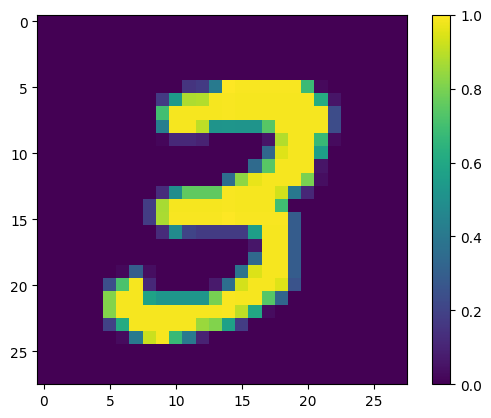

In [5]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

## patch PCA train set

In [6]:
from sklearn.decomposition import PCA
train_images = x_train
# Extracting all quadrants for all images
# First quadrant
first_quadrant = train_images[:, :14, :14]

# Second quadrant
second_quadrant = train_images[:, :14, 14:]

# Third quadrant
third_quadrant = train_images[:, 14:, :14]

# Fourth quadrant
fourth_quadrant = train_images[:, 14:, 14:]

# Extract quadrants
first_quadrant_train = train_images[:, :14, :14].reshape(len(train_images), -1)
second_quadrant_train = train_images[:, :14, 14:].reshape(len(train_images), -1)
third_quadrant_train = train_images[:, 14:, :14].reshape(len(train_images), -1)
fourth_quadrant_train = train_images[:, 14:, 14:].reshape(len(train_images), -1)

# Concatenate quadrants along columns
concatenated_data = np.concatenate([first_quadrant_train, second_quadrant_train, third_quadrant_train, fourth_quadrant_train], axis=0)

# Apply PCA
pca = PCA(n_components=4)  # Adjust n_components as needed
concatenated_pca = pca.fit_transform(concatenated_data)

# Transform each quadrant separately using the same PCA
first_quadrant_pca_train = pca.transform(first_quadrant_train)
second_quadrant_pca_train = pca.transform(second_quadrant_train)
third_quadrant_pca_train = pca.transform(third_quadrant_train)
fourth_quadrant_pca_train = pca.transform(fourth_quadrant_train)

# Display the shape of the transformed quadrants
first_quadrant_pca_train.shape, second_quadrant_pca_train.shape, third_quadrant_pca_train.shape, fourth_quadrant_pca_train.shape

((2046, 4), (2046, 4), (2046, 4), (2046, 4))

In [7]:
x_train_small = np.concatenate([first_quadrant_pca_train[:, :2], second_quadrant_pca_train[:, :2],
                                  first_quadrant_pca_train[:, 2:], second_quadrant_pca_train[:, 2:],
                                  third_quadrant_pca_train[:, :2], fourth_quadrant_pca_train[:, :2],
                                  third_quadrant_pca_train[:, 2:], fourth_quadrant_pca_train[:, 2:]], axis=1).reshape(-1, 4, 4, 1)

## patch PCA test set

In [8]:
test_images = x_test
# Extract quadrants
first_quadrant_test = test_images[:, :14, :14].reshape(len(test_images), -1)
second_quadrant_test = test_images[:, :14, 14:].reshape(len(test_images), -1)
third_quadrant_test = test_images[:, 14:, :14].reshape(len(test_images), -1)
fourth_quadrant_test = test_images[:, 14:, 14:].reshape(len(test_images), -1)

# Transform each quadrant separately using the same PCA
first_quadrant_pca_test = pca.transform(first_quadrant_test)
second_quadrant_pca_test = pca.transform(second_quadrant_test)
third_quadrant_pca_test = pca.transform(third_quadrant_test)
fourth_quadrant_pca_test = pca.transform(fourth_quadrant_test)

x_test_small = np.concatenate([first_quadrant_pca_test[:, :2], second_quadrant_pca_test[:, :2],
                                  first_quadrant_pca_test[:, 2:], second_quadrant_pca_test[:, 2:],
                                  third_quadrant_pca_test[:, :2], fourth_quadrant_pca_test[:, :2],
                                  third_quadrant_pca_test[:, 2:], fourth_quadrant_pca_test[:, 2:]], axis=1).reshape(-1, 4, 4, 1)

True


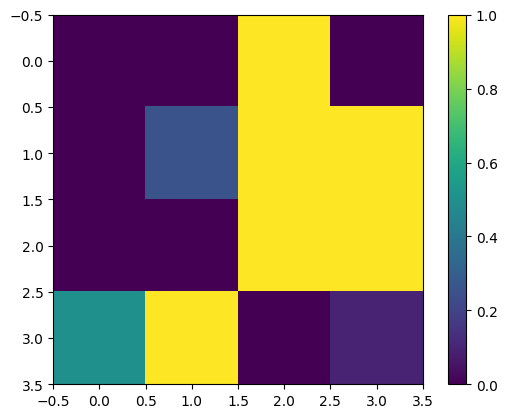

In [9]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

## Data loading circuits

In [10]:
def patch_extractor(img):
    # Extracting 2x2 patches from the image
    patches = [
    tf.constant(img[0:2, 0:2]),  # Top-left
    tf.constant(img[0:2, 2:4]),  # Top-right
    tf.constant(img[2:4, 0:2]),  # Bottom-left
    tf.constant(img[2:4, 2:4])   # Bottom-right
    ]
    return patches

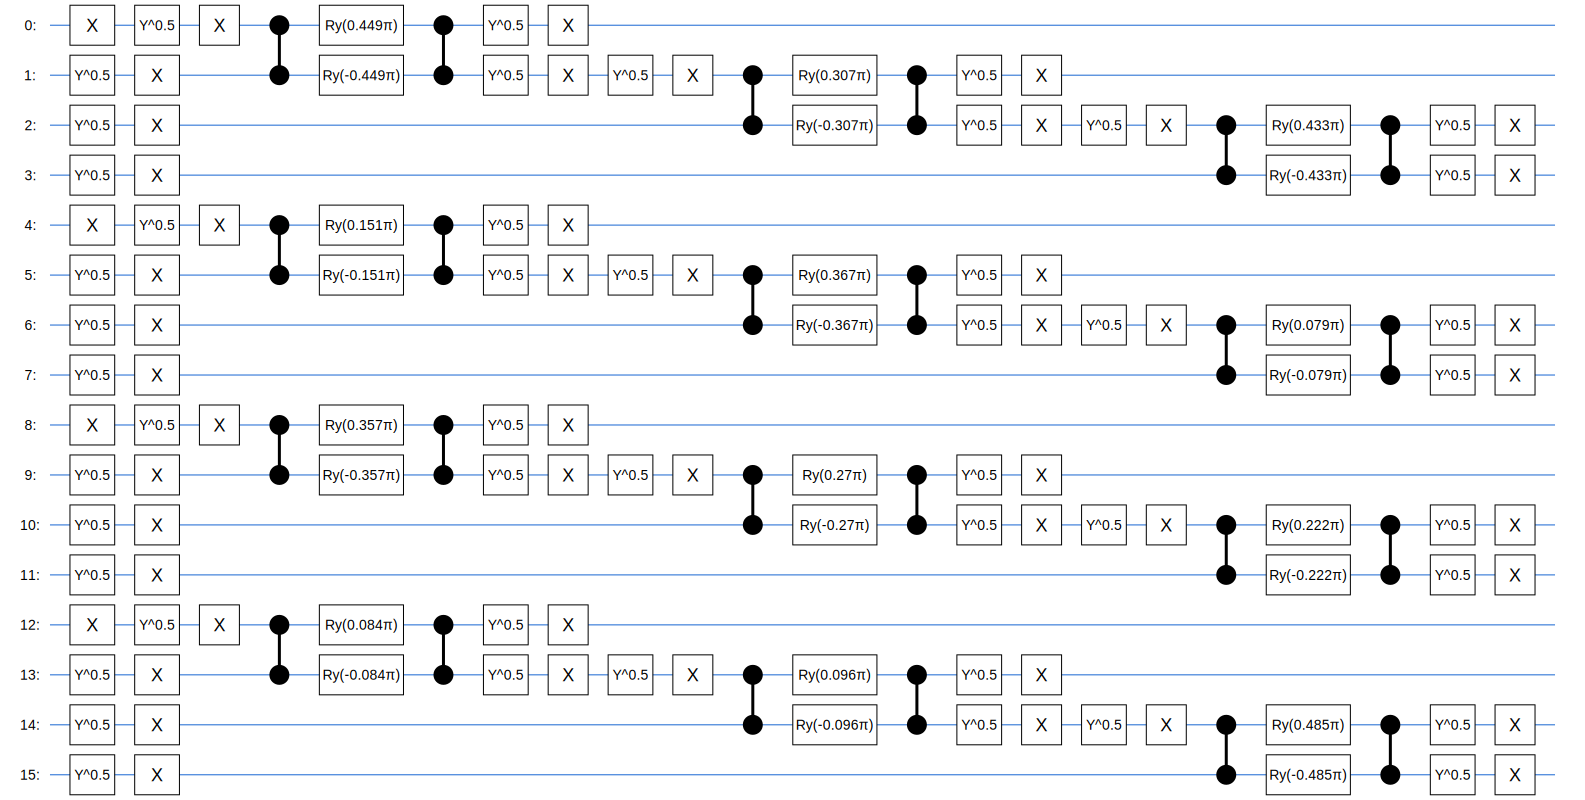

In [11]:
# loading patches as proposed in orthogonal patch wise implementation of Quantum Vision Transformers
def convert_to_circuit(image):
    #initialize circuit
    circuit = cirq.Circuit()
    qubits = [cirq.LineQubit(i) for i in range(16)]

    #divides the image into patches
    patches = patch_extractor(image)
    #load patches into the circuit
    for n in range(len(patches)):
        patch = patches[n]
        flat_patch = tf.reshape(patch, [-1]) 
        alphas = convert_array(flat_patch)
        vector_loader(circuit, alphas, is_x=True, is_conjugate=False, wires=qubits[n*4: 4 + n*4])
    return cirq.Circuit(cirq.decompose(circuit))
SVGCircuit(convert_to_circuit(x_train_small[0]))

In [12]:
x_train_tfcirc = tfq.convert_to_tensor([convert_to_circuit(x) for x in x_train_small])
x_test_tfcirc = tfq.convert_to_tensor([convert_to_circuit(x) for x in x_test_small])

In [13]:
# rbs gate implemented following Quantum Vision Transformers paper description
def build_rbs(circuit, q0, q1, symbol):
    circuit.append(cirq.Moment([cirq.H(q0), cirq.H(q1)]))
    circuit.append(cirq.CZ(q0, q1))
    circuit.append(cirq.Moment([cirq.ry(symbol / 2)(q0), cirq.ry(-symbol / 2)(q1)]))
    circuit.append(cirq.CZ(q0, q1))
    circuit.append(cirq.Moment([cirq.H(q0), cirq.H(q1)]))

In [14]:
# butterfly circuit implemented following Quantum Vision Transformers paper description
def butterfly_circuit(circuit, parameters, wires=None):
    # If wires is None, use all qubits in the circuit
    if wires is None:
        wires = list(circuit.all_qubits())
        length = len(wires)
    else:
        # If wires is not None, ensure it's a list of qubits
        length = len(wires)
    if length > 1:
        n=length//2
        x = 0
        for i in range(n):
            build_rbs(circuit, wires[i], wires[i+n], parameters[x])
            x += 1
        butterfly_circuit(circuit, parameters[x: (len(parameters)//2 + x//2) ], wires = wires[:n])
        butterfly_circuit(circuit, parameters[(len(parameters)//2 + x//2):], wires = wires[n:])

In [15]:
# applies the same butterfly layer to all the loaded patches, simulating a trivial self attention mechanism
# then applies a pyramidal circuit that simulates a 16 to 1 neural network
class CircuitLayerBuilder():
    def __init__(self, data_qubits):
        self.data_qubits = data_qubits

    def add_layer(self, circuit, gate, prefix):
        for n in range(4):
            parameters = [sympy.Symbol(prefix + '-' + str(i)) for i in range(4)]
            butterfly_circuit(circuit, parameters, wires=self.data_qubits[n*4:n*4+4])
        for i in range(len(self.data_qubits) - 2, -1, -1):
            symbol = sympy.Symbol(prefix + '-' + str(i + 4)) 
            q0, q1 = self.data_qubits[i], self.data_qubits[i + 1]
            # Group operations that should execute simultaneously in a Moment
            build_rbs(circuit, q0, q1, symbol)
        circuit.append(cirq.X(self.data_qubits[0]))

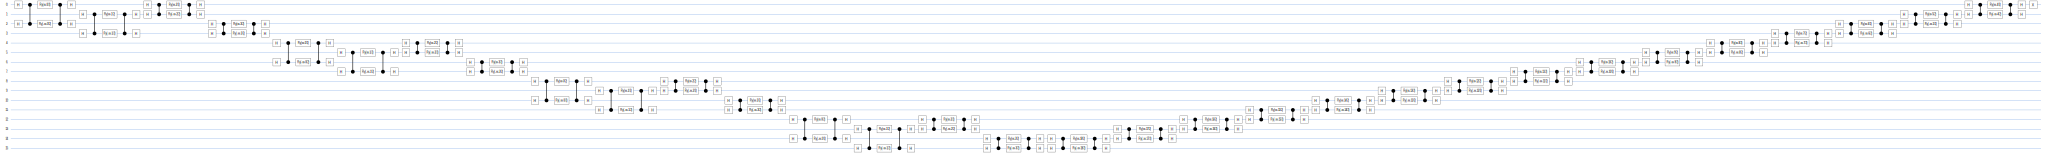

In [16]:
demo_builder = CircuitLayerBuilder(data_qubits = [cirq.LineQubit(i) for i in range(16)])

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
SVGCircuit(circuit)

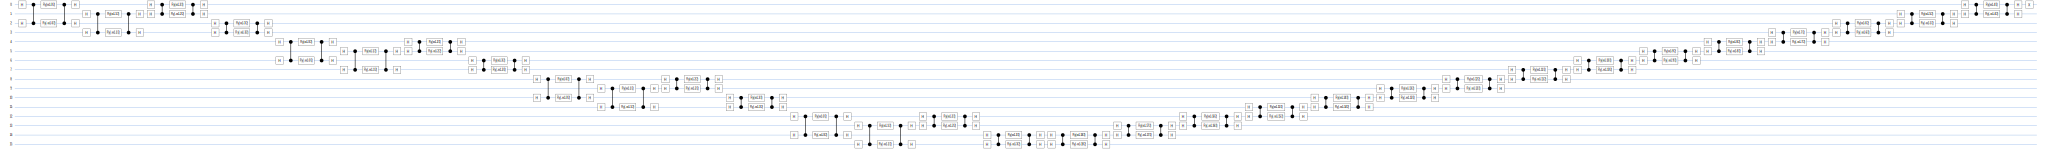

In [17]:
def create_quantum_model(num_qubits=16, layers=[("XX", cirq.XX)]):
    data_qubits = [cirq.LineQubit(i) for i in range(num_qubits)]
    circuit = cirq.Circuit()
    
    builder = CircuitLayerBuilder(data_qubits=data_qubits)
    
    for prefix, gate in layers:
        builder.add_layer(circuit, gate, prefix)
    
    readout = data_qubits[0]
    return circuit, cirq.Z(readout)

num_qubits = 16
layers = [("xx1", cirq.XX)]  
model_circuit, model_readout = create_quantum_model(num_qubits=num_qubits, layers=layers)

SVGCircuit(model_circuit)

In [18]:
model_circuit, model_readout = create_quantum_model()

In [19]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
    # custom layer to map the output to [0,1]
    tf.keras.layers.Lambda(lambda x: x/2 +0.5),
])

In [20]:
model.compile(
    loss='mse',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')] )

In [21]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 19        
                                                                 
 lambda (Lambda)             (None, 1)                 0         
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
EPOCHS = 5
BATCH_SIZE = 32
NUM_EXAMPLES = min(len(x_train_tfcirc), len(y_train))

In [23]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_sub = y_train[:NUM_EXAMPLES]

In [24]:
qnn_history = model.fit(
    x_train_tfcirc, y_train,  
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_data=(x_test_tfcirc, y_test))

Epoch 1/5
64/64 [==============================] - 104s 2s/step - loss: 0.1969 - accuracy: 0.7605 - auc: 0.7970 - val_loss: 0.1252 - val_accuracy: 0.8810 - val_auc: 0.9589
Epoch 2/5
64/64 [==============================] - 94s 1s/step - loss: 0.1052 - accuracy: 0.9096 - auc: 0.9324 - val_loss: 0.1133 - val_accuracy: 0.8789 - val_auc: 0.9490
Epoch 3/5
64/64 [==============================] - 81s 1s/step - loss: 0.1033 - accuracy: 0.9145 - auc: 0.9384 - val_loss: 0.1170 - val_accuracy: 0.8789 - val_auc: 0.8865
Epoch 4/5
64/64 [==============================] - 81s 1s/step - loss: 0.1038 - accuracy: 0.9125 - auc: 0.9444 - val_loss: 0.1208 - val_accuracy: 0.8747 - val_auc: 0.8785
Epoch 5/5
64/64 [==============================] - 93s 1s/step - loss: 0.1040 - accuracy: 0.9106 - auc: 0.9405 - val_loss: 0.1142 - val_accuracy: 0.8747 - val_auc: 0.9175


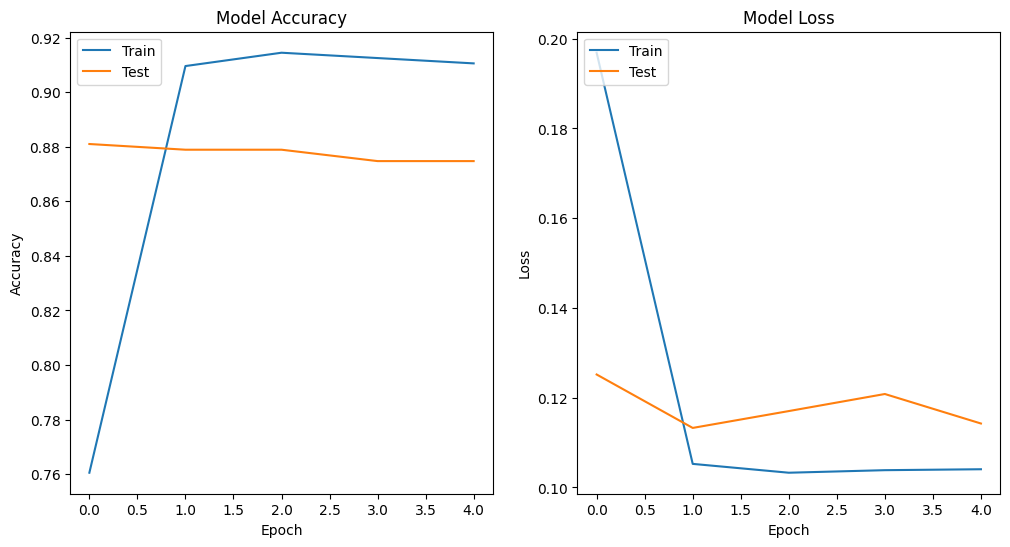

In [25]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(qnn_history.history['accuracy'])
plt.plot(qnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(qnn_history.history['loss'])
plt.plot(qnn_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()